Practice using MAML

In [1]:
import numpy as np

In [2]:
# generate random data
def sample_points(k):
  x = np.random.rand(k, 50)
  y = np.random.choice([0, 1], size=k, p=[0.5, 0.5]).reshape([-1, 1])
  return x, y

In [3]:
x, y = sample_points(10)

In [ ]:
x

In [5]:
y

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]])

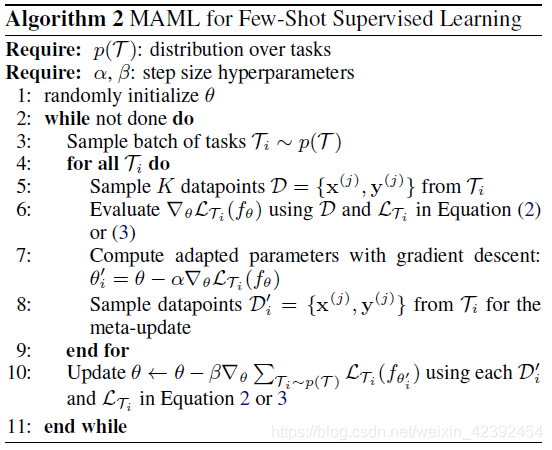

Above image shows MAML algorithm

In [14]:
class MAML(object):
  def __init__(self) -> None:
    self.num_tasks = 10
    self.num_samples = 10
    self.epoches = 10000
    self.alpha = 0.0001 # for inner loop (inner gradient descent)
    self.beta = 0.0001 # for outer loop (outer gradient descent)
    # for whole model's parameters
    self.theta = np.random.normal(size=50).reshape(50, 1)

  def sigmoid(self, a):
    return 1.0/(1+np.exp(-a))
  
  def train(self):
    for e in range(self.epoches):
      self.theta_ = []
      for i in range(self.num_tasks):
        X_train, y_train = sample_points(self.num_samples)
        a = np.matmul(X_train, self.theta)

        Y_hat = self.sigmoid(a)
        # calculate loss 
        loss = ((np.matmul(-y_train.T, np.log(Y_hat))-np.matmul((1-y_train.T), np.log(1-Y_hat)))/self.num_samples)[0][0]
        # update gradient
        gradient = np.matmul(X_train.T, (Y_hat - y_train))/self.num_samples

        self.theta_.append(self.theta - self.alpha*gradient)

      meta_gradient = np.zeros((self.theta.shape))
      for i in range(self.num_tasks):
        # select samples for testing
        X_test, y_test = sample_points(10)
        a = np.matmul(X_test, self.theta_[i])
        y_pred = self.sigmoid(a)

        meta_gradient += np.matmul(X_test.T, (y_pred - y_test))/self.num_samples

      self.theta = self.theta - self.beta*meta_gradient/self.num_tasks
      if e % 1000 ==0:
        print("Epoch {}: loss {}\n".format(e, loss))
        print('Updated Model Parameter theta\n')
        print('Sampling Next Batch of Tasks \n')
        print('---------------------------------\n')

In [15]:
model = MAML()
model.train()

Epoch 8000: loss 1.0024472764057761

Updated Model Parameter theta

Sampling Next Batch of Tasks 

---------------------------------

Epoch 9000: loss 1.5750503657315416

Updated Model Parameter theta

Sampling Next Batch of Tasks 

---------------------------------



----

Ref: https://github.com/Runist/torch_maml

In [1]:
import random
import numpy as np
import glob
from PIL import Image
import torch.nn.functional as F
import torch
import os
import torch
from torch import nn

# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_datasets as tfds

In [2]:
from torch.utils.data.dataset import Dataset

In [3]:
class MAMLDataset(Dataset):

    def __init__(self, data_path, batch_size, n_way=10, k_shot=2, q_query=1):

        self.file_list = self.get_file_list(data_path)
        self.batch_size = batch_size
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query

    def get_file_list(self, data_path):
        raise NotImplementedError('get_file_list function not implemented!')

    def get_one_task_data(self):
        raise NotImplementedError('get_one_task_data function not implemented!')

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, index):
        return self.get_one_task_data()

In [4]:
class OmniglotDataset(MAMLDataset):
    def get_file_list(self, data_path):
        """
        Get all fonts list.
        Args:
            data_path: Omniglot Data path
        Returns: fonts list
        """
        return [f for f in glob.glob(data_path + "**/character*", recursive=True)]

    def get_one_task_data(self):
        """
        Get ones task maml data, include one batch support images and labels, one batch query images and labels.
        Returns: support_data, query_data
        """
        img_dirs = random.sample(self.file_list, self.n_way)
        support_data = []
        query_data = []

        support_image = []
        support_label = []
        query_image = []
        query_label = []

        for label, img_dir in enumerate(img_dirs):
            img_list = [f for f in glob.glob(img_dir + "**/*.png", recursive=True)]
            images = random.sample(img_list, self.k_shot + self.q_query)

            # Read support set
            for img_path in images[:self.k_shot]:
                image = Image.open(img_path)
                image = np.array(image)
                image = np.expand_dims(image / 255., axis=0)
                support_data.append((image, label))

            # Read query set
            for img_path in images[self.k_shot:]:
                image = Image.open(img_path)
                image = np.array(image)
                image = np.expand_dims(image / 255., axis=0)
                query_data.append((image, label))

        # shuffle support set
        random.shuffle(support_data)
        for data in support_data:
            support_image.append(data[0])
            support_label.append(data[1])

        # shuffle query set
        random.shuffle(query_data)
        for data in query_data:
            query_image.append(data[0])
            query_label.append(data[1])

        return np.array(support_image), np.array(support_label), np.array(query_image), np.array(query_label)

In [ ]:
!wget https://github.com/Runist/MAML-keras/releases/download/v1.0/Omniglot.tar
!tar -xvf Omniglot.tar

In [6]:
train_dataset = OmniglotDataset("./Omniglot/images_background/", 32,
                                n_way=5, k_shot=1, q_query=1)
val_dataset = OmniglotDataset("./Omniglot/images_evaluation/", 16,
                              n_way=5, k_shot=1, q_query=1)

In [7]:
from torch.utils.data import DataLoader

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, 
                          shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=16, 
                        shuffle=False, num_workers=12)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
import collections

In [10]:
class ConvBlock(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.conv2d = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv2d(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.max_pool(x)

        return x


def ConvBlockFunction(input, w, b, w_bn, b_bn):
    x = F.conv2d(input, w, b, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=w_bn, bias=b_bn, training=True)
    x = F.relu(x)
    output = F.max_pool2d(x, kernel_size=2, stride=2)

    return output


class Classifier(nn.Module):
    def __init__(self, in_ch, n_way):
        super(Classifier, self).__init__()
        self.conv1 = ConvBlock(in_ch, 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        self.conv4 = ConvBlock(64, 64)
        self.logits = nn.Linear(64, n_way)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.logits(x)

        return x

    def functional_forward(self, x, params):
        x = ConvBlockFunction(x, params[f'conv1.conv2d.weight'], params[f'conv1.conv2d.bias'],
                              params.get(f'conv1.bn.weight'), params.get(f'conv1.bn.bias'))
        x = ConvBlockFunction(x, params[f'conv2.conv2d.weight'], params[f'conv2.conv2d.bias'],
                              params.get(f'conv2.bn.weight'), params.get(f'conv2.bn.bias'))
        x = ConvBlockFunction(x, params[f'conv3.conv2d.weight'], params[f'conv3.conv2d.bias'],
                              params.get(f'conv3.bn.weight'), params.get(f'conv3.bn.bias'))
        x = ConvBlockFunction(x, params[f'conv4.conv2d.weight'], params[f'conv4.conv2d.bias'],
                              params.get(f'conv4.bn.weight'), params.get(f'conv4.bn.bias'))

        x = x.view(x.shape[0], -1)
        x = F.linear(x, params['logits.weight'], params['logits.bias'])

        return x


def maml_train(model, support_images, support_labels, query_images, query_labels, inner_step, optimizer, is_train=True):
    """
    Train the model using MAML method.
    Args:
        model: Any model
        support_images: several task support images
        support_labels: several  support labels
        query_images: several query images
        query_labels: several query labels
        inner_step: support data training step
        args: ArgumentParser
        optimizer: optimizer
        is_train: whether train

    Returns: meta loss, meta accuracy

    """
    meta_loss = []
    meta_acc = []

    for support_image, support_label, query_image, query_label in zip(support_images, support_labels, query_images, query_labels):

        fast_weights = collections.OrderedDict(model.named_parameters())
        for _ in range(inner_step):
            # Update weight
            support_logit = model.functional_forward(support_image, fast_weights)
            support_loss = nn.CrossEntropyLoss().cuda()(support_logit, support_label)
            grads = torch.autograd.grad(support_loss, fast_weights.values(), create_graph=True)
            fast_weights = collections.OrderedDict((name, param - 0.04 * grads)
                                                   for ((name, param), grads) in zip(fast_weights.items(), grads))

        # Use trained weight to get query loss
        query_logit = model.functional_forward(query_image, fast_weights)
        query_prediction = torch.max(query_logit, dim=1)[1]

        query_loss = nn.CrossEntropyLoss().cuda()(query_logit, query_label)
        query_acc = torch.eq(query_label, query_prediction).sum() / len(query_label)

        meta_loss.append(query_loss)
        meta_acc.append(query_acc.data.cpu().numpy())

    # Zero the gradient
    optimizer.zero_grad()
    meta_loss = torch.stack(meta_loss).mean()
    meta_acc = np.mean(meta_acc)

    if is_train:
        meta_loss.backward()
        optimizer.step()

    return meta_loss, meta_acc

In [11]:
model = Classifier(1, 5)

In [12]:
model.train()

Classifier(
  (conv1): ConvBlock(
    (conv2d): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvBlock(
    (conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): ConvBlock(
    (conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): ConvBlock(
    (conv2d): Conv2d(64, 64, kernel_size=(3, 3), 

In [13]:
from tqdm import tqdm
import torch.optim as optim

In [14]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr = 0.001)

In [18]:
for epoch in range(100):
  train_acc = []
  val_acc = []
  train_loss = []
  val_loss = []

  train_bar = tqdm(train_loader)
  for support_images, support_labels, query_images, query_labels in train_bar:
      train_bar.set_description("epoch {}".format(epoch + 1))
      # Get variables
      support_images = support_images.float()
      support_labels = support_labels.long()
      query_images = query_images.float()
      query_labels = query_labels.long()

      loss, acc = maml_train(model, support_images, support_labels, query_images, query_labels,
                              1,  optimizer)

      train_loss.append(loss.item())
      train_acc.append(acc)
      train_bar.set_postfix(loss="{:.4f}".format(loss.item()))

  for support_images, support_labels, query_images, query_labels in val_loader:

      # Get variables
      support_images = support_images.float()
      support_labels = support_labels.long()
      query_images = query_images.float()
      query_labels = query_labels.long()

      loss, acc = maml_train(model, support_images, support_labels, query_images, query_labels,
                              3, optimizer, is_train=False)

      # Must use .item()  to add total loss, or will occur GPU memory leak.
      # Because dynamic graph is created during forward, collect in backward.
      val_loss.append(loss.item())
      val_acc.append(acc)

  print("=> loss: {:.4f}   acc: {:.4f}   val_loss: {:.4f}   val_acc: {:.4f}".
        format(np.mean(train_loss), np.mean(train_acc), np.mean(val_loss), np.mean(val_acc)))

  # if np.mean(val_acc) > best_acc:
  #     best_acc = np.mean(val_acc)
  #     torch.save(model, 'best.pt')

epoch 1: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it, loss=0.9637]


=> loss: 1.0237   acc: 0.6833   val_loss: 0.9032   val_acc: 0.7056


epoch 2: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it, loss=0.8456]


=> loss: 0.9412   acc: 0.7167   val_loss: 0.8609   val_acc: 0.7296


epoch 3: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.7556]


=> loss: 0.8150   acc: 0.7542   val_loss: 0.7445   val_acc: 0.7903


epoch 4: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it, loss=0.6996]


=> loss: 0.7373   acc: 0.7849   val_loss: 0.6223   val_acc: 0.7949


epoch 5: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.6672]


=> loss: 0.6456   acc: 0.8104   val_loss: 0.6797   val_acc: 0.7866


epoch 6: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.6495]


=> loss: 0.5955   acc: 0.8260   val_loss: 0.6027   val_acc: 0.8069


epoch 7: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.5253]


=> loss: 0.5369   acc: 0.8411   val_loss: 0.5137   val_acc: 0.8546


epoch 8: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.5041]


=> loss: 0.5054   acc: 0.8547   val_loss: 0.6180   val_acc: 0.7838


epoch 9: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.4435]


=> loss: 0.4437   acc: 0.8766   val_loss: 0.4616   val_acc: 0.8671


epoch 10: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.3922]


=> loss: 0.3968   acc: 0.8891   val_loss: 0.4285   val_acc: 0.8912


epoch 11: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.3911]


=> loss: 0.4321   acc: 0.8635   val_loss: 0.3993   val_acc: 0.8588


epoch 12: 100%|██████████| 4/4 [00:07<00:00,  1.98s/it, loss=0.3544]


=> loss: 0.3528   acc: 0.8953   val_loss: 0.5109   val_acc: 0.8366


epoch 13: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.3768]


=> loss: 0.3670   acc: 0.8937   val_loss: 0.4316   val_acc: 0.8648


epoch 14: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it, loss=0.2775]


=> loss: 0.3218   acc: 0.9172   val_loss: 0.4202   val_acc: 0.8731


epoch 15: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.3811]


=> loss: 0.3491   acc: 0.8917   val_loss: 0.3776   val_acc: 0.8713


epoch 16: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.2985]


=> loss: 0.2787   acc: 0.9219   val_loss: 0.3465   val_acc: 0.8843


epoch 17: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it, loss=0.3933]


=> loss: 0.3089   acc: 0.8948   val_loss: 0.3504   val_acc: 0.8634


epoch 18: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=0.3336]


=> loss: 0.3295   acc: 0.8922   val_loss: 0.3374   val_acc: 0.8662


epoch 19: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it, loss=0.3197]


=> loss: 0.2940   acc: 0.9089   val_loss: 0.3695   val_acc: 0.8681


epoch 20: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it, loss=0.2806]


=> loss: 0.2828   acc: 0.9073   val_loss: 0.3415   val_acc: 0.9037


epoch 21: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=0.2523]


=> loss: 0.2546   acc: 0.9286   val_loss: 0.3069   val_acc: 0.9171


epoch 22: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=0.2554]


=> loss: 0.2571   acc: 0.9182   val_loss: 0.2852   val_acc: 0.9310


epoch 23: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.2688]


=> loss: 0.2447   acc: 0.9234   val_loss: 0.3316   val_acc: 0.8921


epoch 24: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it, loss=0.2029]


=> loss: 0.2273   acc: 0.9255   val_loss: 0.3570   val_acc: 0.8556


epoch 25: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.2370]


=> loss: 0.2291   acc: 0.9380   val_loss: 0.3313   val_acc: 0.8856


epoch 26: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=0.2700]


=> loss: 0.2518   acc: 0.9214   val_loss: 0.3579   val_acc: 0.8931


epoch 27: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.3440]


=> loss: 0.2656   acc: 0.9224   val_loss: 0.3611   val_acc: 0.8579


epoch 28: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it, loss=0.2687]


=> loss: 0.2525   acc: 0.9125   val_loss: 0.3169   val_acc: 0.8963


epoch 29: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.2267]


=> loss: 0.2339   acc: 0.9276   val_loss: 0.2930   val_acc: 0.8954


epoch 30: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.2440]


=> loss: 0.2168   acc: 0.9318   val_loss: 0.2724   val_acc: 0.9343


epoch 31: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.2321]


=> loss: 0.2080   acc: 0.9464   val_loss: 0.2926   val_acc: 0.9194


epoch 32: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it, loss=0.1771]


=> loss: 0.2094   acc: 0.9344   val_loss: 0.2802   val_acc: 0.9259


epoch 33: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.2997]


=> loss: 0.2560   acc: 0.9193   val_loss: 0.3054   val_acc: 0.8977


epoch 34: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.1704]


=> loss: 0.2027   acc: 0.9427   val_loss: 0.4251   val_acc: 0.8653


epoch 35: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.1299]


=> loss: 0.1978   acc: 0.9484   val_loss: 0.2494   val_acc: 0.9153


epoch 36: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=0.1530]


=> loss: 0.1882   acc: 0.9422   val_loss: 0.2933   val_acc: 0.9046


epoch 37: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=0.2221]


=> loss: 0.2358   acc: 0.9229   val_loss: 0.3566   val_acc: 0.8699


epoch 38: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.1720]


=> loss: 0.1985   acc: 0.9417   val_loss: 0.2634   val_acc: 0.9292


epoch 39: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.2404]


=> loss: 0.2128   acc: 0.9365   val_loss: 0.2366   val_acc: 0.9310


epoch 40: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.2081]


=> loss: 0.1957   acc: 0.9385   val_loss: 0.2640   val_acc: 0.9171


epoch 41: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=0.2106]


=> loss: 0.1794   acc: 0.9354   val_loss: 0.2825   val_acc: 0.9097


epoch 42: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it, loss=0.2455]


=> loss: 0.2057   acc: 0.9391   val_loss: 0.2780   val_acc: 0.9130


epoch 43: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.1823]


=> loss: 0.2001   acc: 0.9417   val_loss: 0.3037   val_acc: 0.8889


epoch 44: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it, loss=0.2115]


=> loss: 0.2083   acc: 0.9260   val_loss: 0.2672   val_acc: 0.9130


epoch 45: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.1825]


=> loss: 0.2121   acc: 0.9349   val_loss: 0.2436   val_acc: 0.9153


epoch 46: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.2282]


=> loss: 0.2179   acc: 0.9312   val_loss: 0.2559   val_acc: 0.9056


epoch 47: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.1769]


=> loss: 0.1741   acc: 0.9479   val_loss: 0.2450   val_acc: 0.9194


epoch 48: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.1980]


=> loss: 0.1954   acc: 0.9411   val_loss: 0.3233   val_acc: 0.9046


epoch 49: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it, loss=0.2155]


=> loss: 0.2193   acc: 0.9375   val_loss: 0.3385   val_acc: 0.8676


epoch 50: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=0.0937]


=> loss: 0.1474   acc: 0.9708   val_loss: 0.2161   val_acc: 0.9296


epoch 51: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it, loss=0.1211]


=> loss: 0.1476   acc: 0.9453   val_loss: 0.2719   val_acc: 0.9319


epoch 52: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it, loss=0.1617]


=> loss: 0.1798   acc: 0.9432   val_loss: 0.3001   val_acc: 0.8931


epoch 53: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it, loss=0.1788]


=> loss: 0.1994   acc: 0.9375   val_loss: 0.2744   val_acc: 0.9130


epoch 54: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=0.2101]


=> loss: 0.1684   acc: 0.9448   val_loss: 0.2389   val_acc: 0.9171


epoch 55: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=0.2121]


=> loss: 0.2188   acc: 0.9286   val_loss: 0.2388   val_acc: 0.9245


epoch 56: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.1564]


=> loss: 0.1750   acc: 0.9542   val_loss: 0.2368   val_acc: 0.9227


epoch 57: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it, loss=0.1510]


=> loss: 0.1592   acc: 0.9510   val_loss: 0.2810   val_acc: 0.8889


epoch 58: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.1972]


=> loss: 0.1711   acc: 0.9448   val_loss: 0.2293   val_acc: 0.9319


epoch 59: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it, loss=0.1554]


=> loss: 0.1623   acc: 0.9417   val_loss: 0.1720   val_acc: 0.9676


epoch 60: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it, loss=0.1345]


=> loss: 0.1709   acc: 0.9474   val_loss: 0.2413   val_acc: 0.9120


epoch 61: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it, loss=0.2675]


=> loss: 0.1828   acc: 0.9464   val_loss: 0.1832   val_acc: 0.9542


epoch 62: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.1660]


=> loss: 0.1658   acc: 0.9448   val_loss: 0.2960   val_acc: 0.8875


epoch 63: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it, loss=0.1422]


=> loss: 0.1864   acc: 0.9391   val_loss: 0.2396   val_acc: 0.8940


epoch 64: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it, loss=0.1901]


=> loss: 0.1945   acc: 0.9354   val_loss: 0.1715   val_acc: 0.9361


epoch 65: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it, loss=0.2392]


=> loss: 0.1753   acc: 0.9490   val_loss: 0.2667   val_acc: 0.9144


epoch 66: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it, loss=0.2217]


=> loss: 0.1623   acc: 0.9474   val_loss: 0.2529   val_acc: 0.9264


epoch 67: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.1028]


=> loss: 0.1349   acc: 0.9641   val_loss: 0.2842   val_acc: 0.9014


epoch 68: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.1013]


=> loss: 0.1504   acc: 0.9536   val_loss: 0.1551   val_acc: 0.9667


epoch 69: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.1322]


=> loss: 0.1336   acc: 0.9693   val_loss: 0.2698   val_acc: 0.8806


epoch 70: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it, loss=0.1530]


=> loss: 0.1426   acc: 0.9557   val_loss: 0.2483   val_acc: 0.9176


epoch 71: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it, loss=0.1085]


=> loss: 0.1284   acc: 0.9521   val_loss: 0.2561   val_acc: 0.8958


epoch 72: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.1050]


=> loss: 0.1351   acc: 0.9542   val_loss: 0.2068   val_acc: 0.9426


epoch 73: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.1222]


=> loss: 0.1703   acc: 0.9495   val_loss: 0.2541   val_acc: 0.9153


epoch 74: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.2151]


=> loss: 0.1852   acc: 0.9375   val_loss: 0.2624   val_acc: 0.8963


epoch 75: 100%|██████████| 4/4 [00:08<00:00,  2.00s/it, loss=0.1190]


=> loss: 0.1575   acc: 0.9505   val_loss: 0.2150   val_acc: 0.9426


epoch 76: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.1192]


=> loss: 0.1686   acc: 0.9505   val_loss: 0.1840   val_acc: 0.9417


epoch 77: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.1308]


=> loss: 0.1632   acc: 0.9469   val_loss: 0.2366   val_acc: 0.9171


epoch 78: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.2260]


=> loss: 0.1580   acc: 0.9536   val_loss: 0.1692   val_acc: 0.9486


epoch 79: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it, loss=0.1453]


=> loss: 0.1394   acc: 0.9635   val_loss: 0.1862   val_acc: 0.9551


epoch 80: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it, loss=0.1654]


=> loss: 0.1475   acc: 0.9599   val_loss: 0.2510   val_acc: 0.9259


epoch 81: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it, loss=0.1474]


=> loss: 0.1418   acc: 0.9547   val_loss: 0.2577   val_acc: 0.9222


epoch 82: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.2155]


=> loss: 0.1586   acc: 0.9542   val_loss: 0.2221   val_acc: 0.9144


epoch 83: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.1995]


=> loss: 0.1904   acc: 0.9401   val_loss: 0.2875   val_acc: 0.9014


epoch 84: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.2195]


=> loss: 0.1708   acc: 0.9458   val_loss: 0.2457   val_acc: 0.9037


epoch 85: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it, loss=0.1449]


=> loss: 0.1751   acc: 0.9385   val_loss: 0.2704   val_acc: 0.8963


epoch 86: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it, loss=0.1688]


=> loss: 0.1714   acc: 0.9573   val_loss: 0.1993   val_acc: 0.9227


epoch 87: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.1283]


=> loss: 0.1467   acc: 0.9552   val_loss: 0.3079   val_acc: 0.8690


epoch 88: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.1857]


=> loss: 0.1526   acc: 0.9609   val_loss: 0.2101   val_acc: 0.9477


epoch 89: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it, loss=0.1354]


=> loss: 0.1265   acc: 0.9635   val_loss: 0.1627   val_acc: 0.9509


epoch 90: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.1675]


=> loss: 0.1385   acc: 0.9635   val_loss: 0.2104   val_acc: 0.9417


epoch 91: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.1235]


=> loss: 0.1033   acc: 0.9724   val_loss: 0.2015   val_acc: 0.9278


epoch 92: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it, loss=0.1679]


=> loss: 0.1419   acc: 0.9563   val_loss: 0.2293   val_acc: 0.9102


epoch 93: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=0.1445]


=> loss: 0.1343   acc: 0.9526   val_loss: 0.2424   val_acc: 0.8995


epoch 94: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.1520]


=> loss: 0.1331   acc: 0.9661   val_loss: 0.1381   val_acc: 0.9505


epoch 95: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=0.1478]


=> loss: 0.1711   acc: 0.9406   val_loss: 0.1923   val_acc: 0.9088


epoch 96: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.0983]


=> loss: 0.1196   acc: 0.9651   val_loss: 0.2027   val_acc: 0.9310


epoch 97: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.1405]


=> loss: 0.1496   acc: 0.9552   val_loss: 0.2515   val_acc: 0.9111


epoch 98: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it, loss=0.1196]


=> loss: 0.1289   acc: 0.9672   val_loss: 0.1682   val_acc: 0.9435


epoch 99: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, loss=0.1730]


=> loss: 0.1534   acc: 0.9490   val_loss: 0.2126   val_acc: 0.9468


epoch 100: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it, loss=0.1523]


=> loss: 0.1338   acc: 0.9698   val_loss: 0.1861   val_acc: 0.9551
